In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
df=pd.read_csv("AAPL.csv",parse_dates=["Date"],index_col=[0])
print(df.index.freq)
missing_dates = pd.date_range(start=df.index.min(), end=df.index.max()).difference(df.index)
print(missing_dates)
df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'AAPL.csv'

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-07-01,14.381786,14.723929,14.329286,14.615000,12.688703,391053600
2013-07-02,14.641429,15.058214,14.623929,14.946071,12.976134,469865200
2013-07-03,15.030714,15.106429,14.908929,15.028571,13.047762,240928800
2013-07-05,15.013929,15.117500,14.833929,14.907857,12.942959,274024800
2013-07-08,15.003929,15.035714,14.666071,14.823214,12.869470,298138400


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-26,186.830002,188.050003,185.229996,185.270004,185.270004,48088700
2023-06-27,185.889999,188.389999,185.669998,188.059998,188.059998,50730800
2023-06-28,187.929993,189.899994,187.600006,189.250000,189.250000,51216800
2023-06-29,189.080002,190.070007,188.940002,189.589996,189.589996,46347300
2023-06-30,191.630005,194.479996,191.259995,193.970001,193.970001,85069600


In [6]:
def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test
df_train, df_test = train_test_split(df, 0.2)

In [7]:
print(df_train.shape)
print(df_test.shape)

(2014, 6)
(504, 6)


In [8]:
# 归一化
scaler = MinMaxScaler(feature_range=(0,1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

In [9]:
df_train_scaled

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33880404],
       [0.00200934, 0.0025642 , 0.00231928, 0.00257553, 0.00223922,
        0.41606462],
       [0.00502195, 0.00293405, 0.00456266, 0.00321732, 0.00279723,
        0.19163371],
       ...,
       [0.9215281 , 0.9140881 , 0.93262005, 0.92181724, 0.92612438,
        0.02483709],
       [0.92114114, 0.92452027, 0.93687072, 0.93480878, 0.93898379,
        0.01633536],
       [0.93189813, 0.93403198, 0.94474221, 0.94686684, 0.95091897,
        0.01873205]])

In [10]:
df_test_scaled

array([[9.42500307e-01, 9.41089026e-01, 9.56706791e-01, 9.51767888e-01,
        9.55770295e-01, 1.74628302e-02],
       [9.45828073e-01, 9.40475354e-01, 9.55840927e-01, 9.54179472e-01,
        9.58157373e-01, 6.89929527e-03],
       [9.55888481e-01, 9.60956128e-01, 9.71505236e-01, 9.75106018e-01,
        9.78870838e-01, 3.27471935e-02],
       ...,
       [1.34306298e+00, 1.34372440e+00, 1.36389919e+00, 1.35855144e+00,
        1.37549128e+00, 5.65526934e-03],
       [1.35196272e+00, 1.34502852e+00, 1.37444696e+00, 1.36119639e+00,
        1.37814000e+00, 8.81601670e-04],
       [1.37169680e+00, 1.37885626e+00, 1.39270877e+00, 1.39527010e+00,
        1.41226219e+00, 3.88418422e-02]])

In [11]:
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#             dataY.append(dataset[i,0])
#     return np.array(dataX),np.array(dataY)

In [12]:
def generate_time_series_data(input_data, history_length):
    X_data, Y_data = [], []

    for idx in range(history_length, len(input_data)):
        X_data.append(input_data[idx-history_length :idx, 0:input_data.shape[1]])
        Y_data.append(input_data[idx, 0]) #这里，对于每个 idx，我们只取第一个特征的值作为输出。这意味着我们正在尝试预测每个时间点的第一个特征的值

    return np.array(X_data), np.array(Y_data)

In [13]:
#假设你只想预测第1、第3和第5个特征（记住，索引是从0开始的）
#Y_data.append(input_data[idx, [0, 2, 4]])

In [14]:
df_train_scaled.shape[1] #总共6列值

6

In [15]:
trainX,trainY=generate_time_series_data(df_train_scaled,30)
testX,testY=generate_time_series_data(df_test_scaled,30)

In [16]:
print("trainX Shape-- ",trainX.shape) #trainX consists of 1984 time Windows, each consisting of 30 consecutive time steps with 6 features per time step
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (1984, 30, 6)
trainY Shape--  (1984,)


In [17]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (474, 30, 6)
testY Shape--  (474,)


In [18]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.         0.         0.         0.         0.         0.33880404]
 [0.00200934 0.0025642  0.00231928 0.00257553 0.00223922 0.41606462]
 [0.00502195 0.00293405 0.00456266 0.00321732 0.00279723 0.19163371]
 [0.00489206 0.00301897 0.00397229 0.00227824 0.00198077 0.22407838]
 [0.00481467 0.00239161 0.002651   0.00161978 0.00140826 0.24771742]
 [0.00301539 0.0030765  0.0025751  0.00364798 0.00317164 0.30109192]
 [0.00467371 0.00343264 0.00478755 0.00319788 0.00278032 0.23131393]
 [0.00559961 0.00437778 0.00560844 0.00502048 0.00436496 0.27531735]
 [0.00689862 0.00479967 0.00623816 0.00480377 0.00417651 0.22950779]
 [0.00616897 0.00525717 0.00662892 0.00506215 0.00440116 0.19260266]
 [0.00658631 0.00505171 0.00645181 0.00582898 0.0050679  0.16772293]
 [0.00746522 0.00546538 0.00759036 0.00585954 0.00509445 0.15052067]
 [0.00848233 0.00619135 0.00826226 0.0062624  0.00544472 0.17001766]
 [0.00840494 0.00594754 0.00650241 0.00437034 0.0037997  0.21887955]
 [0.00739889 0.00478

In [19]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [20]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,6)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [ 32, 64], # , 128, 256, 512
              'epochs' : [ 50, 100], # , 200
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\eq220\AppData\Local\Temp\ipykernel_10680\3563693491.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [ ]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from tensorflow.keras.optimizers import Adam


# 定义超参数空间
space  = [Integer(32, 256, name='lstm_neurons'),
          Real(0.1, 0.9, name='dropout_rate'),
          Real(1e-4, 1e-2, name='learning_rate', prior='log-uniform')]

# 定义优化目标函数
@use_named_args(space)
def objective(**params):
    # 在这里构建您的 LSTM 模型
    model = Sequential()
    model.add(LSTM(params['lstm_neurons'], input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    
    history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), verbose=0, shuffle=False)
    
    # 返回验证损失
    return history.history['val_loss'][-1]

# 执行贝叶斯优化
res = gp_minimize(objective, space, n_calls=50, random_state=0)

# 输出最佳参数
print("Best parameters: {}".format(res.x))


In [21]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/50
31/31 [==============================] - 7s 74ms/step - loss: 0.0237 - val_loss: 0.0062
Epoch 2/50
31/31 [==============================] - 1s 42ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 3/50
31/31 [==============================] - 1s 33ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 4/50
31/31 [==============================] - 1s 39ms/step - loss: 0.0026 - val_loss: 0.0069
Epoch 5/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 6/50
31/31 [==============================] - 1s 36ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 7/50
31/31 [==============================] - 1s 34ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 8/50
31/31 [==============================] - 1s 29ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 9/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 10/50
31/31 [==============================] - 1s 30ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/

Epoch 11/50
31/31 [==============================] - 1s 43ms/step - loss: 0.0084 - val_loss: 1.3961
Epoch 12/50
31/31 [==============================] - 1s 49ms/step - loss: 0.0082 - val_loss: 1.3834
Epoch 13/50
31/31 [==============================] - 1s 43ms/step - loss: 0.0080 - val_loss: 1.3709
Epoch 14/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0077 - val_loss: 1.3583
Epoch 15/50
31/31 [==============================] - 1s 35ms/step - loss: 0.0075 - val_loss: 1.3458
Epoch 16/50
31/31 [==============================] - 2s 56ms/step - loss: 0.0072 - val_loss: 1.3336
Epoch 17/50
31/31 [==============================] - 2s 52ms/step - loss: 0.0071 - val_loss: 1.3214
Epoch 18/50
31/31 [==============================] - 1s 44ms/step - loss: 0.0069 - val_loss: 1.3094
Epoch 19/50
31/31 [==============================] - 2s 58ms/step - loss: 0.0066 - val_loss: 1.2975
Epoch 20/50
31/31 [==============================] - 1s 43ms/step - loss: 0.0065 - val_loss: 1.2857


Epoch 42/100
31/31 [==============================] - 1s 38ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 43/100
31/31 [==============================] - 1s 35ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 44/100
31/31 [==============================] - 1s 43ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 45/100
31/31 [==============================] - 2s 52ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 46/100
31/31 [==============================] - 1s 35ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 47/100
31/31 [==============================] - 1s 38ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 48/100
31/31 [==============================] - 1s 39ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 49/100
31/31 [==============================] - 2s 50ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 50/100
31/31 [==============================] - 1s 38ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 51/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0012 - val_los

31/31 [==============================] - 2s 52ms/step - loss: 2.3720e-05 - val_loss: 8.5421e-04
Epoch 98/100
31/31 [==============================] - 1s 39ms/step - loss: 2.4678e-05 - val_loss: 4.6348e-04
Epoch 99/100
31/31 [==============================] - 1s 42ms/step - loss: 2.4003e-05 - val_loss: 4.5771e-04
Epoch 100/100
31/31 [==============================] - 1s 26ms/step - loss: 1.9288e-04
Epoch 1/100
31/31 [==============================] - 7s 94ms/step - loss: 0.1923 - val_loss: 0.9686
Epoch 2/100
31/31 [==============================] - 2s 56ms/step - loss: 0.1857 - val_loss: 0.9491
Epoch 3/100
31/31 [==============================] - 1s 47ms/step - loss: 0.1838 - val_loss: 0.9294
Epoch 4/100
31/31 [==============================] - 2s 52ms/step - loss: 0.1773 - val_loss: 0.9099
Epoch 5/100
31/31 [==============================] - 2s 52ms/step - loss: 0.1690 - val_loss: 0.8904
Epoch 6/100
31/31 [==============================] - 2s 58ms/step - loss: 0.1691 - val_loss: 0.8711

31/31 [==============================] - 1s 44ms/step - loss: 0.0030 - val_loss: 0.9424
Epoch 58/100
31/31 [==============================] - 2s 53ms/step - loss: 0.0031 - val_loss: 0.9363
Epoch 59/100
31/31 [==============================] - 2s 53ms/step - loss: 0.0030 - val_loss: 0.9305
Epoch 60/100
31/31 [==============================] - 2s 48ms/step - loss: 0.0029 - val_loss: 0.9248
Epoch 61/100
31/31 [==============================] - 1s 46ms/step - loss: 0.0029 - val_loss: 0.9191
Epoch 62/100
31/31 [==============================] - 2s 56ms/step - loss: 0.0027 - val_loss: 0.9137
Epoch 63/100
31/31 [==============================] - 1s 41ms/step - loss: 0.0028 - val_loss: 0.9083
Epoch 64/100
31/31 [==============================] - 2s 55ms/step - loss: 0.0027 - val_loss: 0.9030
Epoch 65/100
31/31 [==============================] - 1s 33ms/step - loss: 0.0027 - val_loss: 0.8977
Epoch 66/100
31/31 [==============================] - 1s 41ms/step - loss: 0.0026 - val_loss: 0.8926
Epo

Epoch 38/50
16/16 [==============================] - 1s 82ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 39/50
16/16 [==============================] - 2s 112ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 40/50
16/16 [==============================] - 1s 92ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 41/50
16/16 [==============================] - 2s 95ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 42/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 43/50
16/16 [==============================] - 2s 93ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 44/50
16/16 [==============================] - 2s 97ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 45/50
16/16 [==============================] - 1s 95ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 46/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 47/50
16/16 [==============================] - 1s 73ms/step - loss: 0.0018 - val_loss: 0.0034

16/16 [==============================] - 1s 54ms/step - loss: 0.0096 - val_loss: 1.2756
Epoch 48/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0094 - val_loss: 1.2688
Epoch 49/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0092 - val_loss: 1.2620
Epoch 50/50
16/16 [==============================] - 0s 18ms/step - loss: 0.2619
Epoch 1/100
16/16 [==============================] - 8s 140ms/step - loss: 0.0301 - val_loss: 0.0917
Epoch 2/100
16/16 [==============================] - 1s 81ms/step - loss: 0.0066 - val_loss: 0.0261
Epoch 3/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0045 - val_loss: 0.0108
Epoch 4/100
16/16 [==============================] - 1s 69ms/step - loss: 0.0036 - val_loss: 0.0095
Epoch 5/100
16/16 [==============================] - 2s 97ms/step - loss: 0.0030 - val_loss: 0.0067
Epoch 6/100
16/16 [==============================] - 1s 51ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/100
16/16 [===========

16/16 [==============================] - 2s 107ms/step - loss: 4.7637e-05 - val_loss: 0.0015
Epoch 56/100
16/16 [==============================] - 1s 84ms/step - loss: 4.8978e-05 - val_loss: 0.0011
Epoch 57/100
16/16 [==============================] - 1s 65ms/step - loss: 4.6513e-05 - val_loss: 0.0020
Epoch 58/100
16/16 [==============================] - 1s 78ms/step - loss: 4.7999e-05 - val_loss: 0.0012
Epoch 59/100
16/16 [==============================] - 1s 82ms/step - loss: 4.2829e-05 - val_loss: 9.7060e-04
Epoch 60/100
16/16 [==============================] - 1s 74ms/step - loss: 4.6368e-05 - val_loss: 9.6259e-04
Epoch 61/100
16/16 [==============================] - 1s 70ms/step - loss: 4.7537e-05 - val_loss: 9.7795e-04
Epoch 62/100
16/16 [==============================] - 1s 77ms/step - loss: 4.3956e-05 - val_loss: 0.0018
Epoch 63/100
16/16 [==============================] - 1s 74ms/step - loss: 4.6414e-05 - val_loss: 0.0016
Epoch 64/100
16/16 [==============================] - 2

Epoch 33/100
16/16 [==============================] - 1s 82ms/step - loss: 0.1431 - val_loss: 0.7602
Epoch 34/100
16/16 [==============================] - 2s 91ms/step - loss: 0.1428 - val_loss: 0.7517
Epoch 35/100
16/16 [==============================] - 1s 64ms/step - loss: 0.1427 - val_loss: 0.7431
Epoch 36/100
16/16 [==============================] - 1s 56ms/step - loss: 0.1397 - val_loss: 0.7346
Epoch 37/100
16/16 [==============================] - 1s 77ms/step - loss: 0.1358 - val_loss: 0.7259
Epoch 38/100
16/16 [==============================] - 2s 103ms/step - loss: 0.1365 - val_loss: 0.7173
Epoch 39/100
16/16 [==============================] - 1s 87ms/step - loss: 0.1340 - val_loss: 0.7087
Epoch 40/100
16/16 [==============================] - 1s 71ms/step - loss: 0.1312 - val_loss: 0.7001
Epoch 41/100
16/16 [==============================] - 1s 60ms/step - loss: 0.1261 - val_loss: 0.6915
Epoch 42/100
16/16 [==============================] - 1s 82ms/step - loss: 0.1264 - val_lo

16/16 [==============================] - 1s 73ms/step - loss: 0.0016 - val_loss: 0.6254
Epoch 95/100
16/16 [==============================] - 1s 61ms/step - loss: 0.0015 - val_loss: 0.6234
Epoch 96/100
16/16 [==============================] - 1s 74ms/step - loss: 0.0015 - val_loss: 0.6215
Epoch 97/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0015 - val_loss: 0.6195
Epoch 98/100
16/16 [==============================] - 1s 63ms/step - loss: 0.0015 - val_loss: 0.6175
Epoch 99/100
16/16 [==============================] - 2s 99ms/step - loss: 0.0014 - val_loss: 0.6156
Epoch 100/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0960
Epoch 1/100
62/62 [==============================] - 9s 77ms/step - loss: 0.0193 - val_loss: 0.0038
Epoch 2/100
62/62 [==============================] - 3s 50ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 3/100
62/62 [==============================] - 3s 52ms/step - loss: 0.0015 - val_loss: 0.0092
Epoch 4/100
62/62 [====

Epoch 72/100
62/62 [==============================] - 4s 58ms/step - loss: 5.1572e-04 - val_loss: 0.0022
Epoch 73/100
62/62 [==============================] - 3s 48ms/step - loss: 5.8104e-04 - val_loss: 6.6905e-04
Epoch 74/100
62/62 [==============================] - 5s 73ms/step - loss: 4.9667e-04 - val_loss: 0.0060
Epoch 75/100
62/62 [==============================] - 5s 78ms/step - loss: 5.7942e-04 - val_loss: 0.0032
Epoch 76/100
62/62 [==============================] - 3s 51ms/step - loss: 4.5330e-04 - val_loss: 9.9500e-04
Epoch 77/100
62/62 [==============================] - 5s 82ms/step - loss: 5.2690e-04 - val_loss: 0.0011
Epoch 78/100
62/62 [==============================] - 4s 64ms/step - loss: 4.5363e-04 - val_loss: 0.0025
Epoch 79/100
62/62 [==============================] - 6s 93ms/step - loss: 5.0081e-04 - val_loss: 0.0027
Epoch 80/100
62/62 [==============================] - 5s 87ms/step - loss: 4.6492e-04 - val_loss: 8.7069e-04
Epoch 81/100
62/62 [=======================

In [22]:
grid_search.best_params_

{'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}

In [24]:
my_model=grid_search.best_estimator_.model

In [25]:
my_model

In [26]:
prediction=my_model.predict(testX)

15/15 [==============================] - 2s 29ms/step


In [27]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.9901055 ]
 [1.0000424 ]
 [1.0088454 ]
 [1.0134742 ]
 [1.0172639 ]
 [1.002533  ]
 [0.99198264]
 [0.999435  ]
 [1.009002  ]
 [1.0144069 ]
 [1.009774  ]
 [1.0041944 ]
 [1.0037242 ]
 [1.0225303 ]
 [1.0291309 ]
 [1.0351877 ]
 [1.0395119 ]
 [1.0427263 ]
 [1.053839  ]
 [1.0522715 ]
 [1.047183  ]
 [1.0228908 ]
 [1.0138311 ]
 [1.0058496 ]
 [1.0041811 ]
 [1.0049481 ]
 [0.99553025]
 [0.97301775]
 [0.9719804 ]
 [0.9816457 ]
 [0.99193543]
 [0.994428  ]
 [0.9866402 ]
 [0.96983314]
 [0.9683382 ]
 [0.96436507]
 [0.9609096 ]
 [0.94973963]
 [0.95224756]
 [0.9542691 ]
 [0.9686606 ]
 [0.9715625 ]
 [0.9699526 ]
 [0.9640773 ]
 [0.955366  ]
 [0.9664332 ]
 [0.977119  ]
 [0.984692  ]
 [1.0011032 ]
 [1.0097313 ]
 [1.011008  ]
 [1.01085   ]
 [1.0076141 ]
 [1.0120435 ]
 [1.0102916 ]
 [1.023681  ]
 [1.0100894 ]
 [1.008494  ]
 [1.013422  ]
 [1.0218503 ]
 [1.0244946 ]
 [1.0249314 ]
 [1.0221806 ]
 [1.0214376 ]
 [1.0095129 ]
 [1.005629  ]
 [1.0103581 ]
 [1.0173469 ]
 [1.0206742 ]
 [1.0333574 ]
 [1.0542

In [28]:
# scaler.inverse_transform(prediction)

In [29]:
prediction_copies = np.repeat(prediction, 6, axis=-1)
inverse_transformed_data = scaler.inverse_transform(prediction_copies)

In [30]:
# prediction_copies_array = np.repeat(prediction, 6, axis=-1)

In [31]:
prediction_copies.shape

(474, 6)

In [32]:
prediction_copies

array([[0.9901055, 0.9901055, 0.9901055, 0.9901055, 0.9901055, 0.9901055],
       [1.0000424, 1.0000424, 1.0000424, 1.0000424, 1.0000424, 1.0000424],
       [1.0088454, 1.0088454, 1.0088454, 1.0088454, 1.0088454, 1.0088454],
       ...,
       [1.2513609, 1.2513609, 1.2513609, 1.2513609, 1.2513609, 1.2513609],
       [1.2609403, 1.2609403, 1.2609403, 1.2609403, 1.2609403, 1.2609403],
       [1.265208 , 1.265208 , 1.265208 , 1.265208 , 1.265208 , 1.265208 ]],
      dtype=float32)

In [47]:
pred=scaler.inverse_transform(prediction_copies)[:,0]

In [48]:
pred

array([142.32146 , 143.60548 , 144.743   , 145.34113 , 145.83081 ,
       143.9273  , 142.56401 , 143.527   , 144.76323 , 145.46164 ,
       144.86298 , 144.142   , 144.08124 , 146.51134 , 147.36426 ,
       148.1469  , 148.70567 , 149.12102 , 150.55698 , 150.35443 ,
       149.69691 , 146.55792 , 145.38724 , 144.35588 , 144.14029 ,
       144.2394  , 143.02243 , 140.1134  , 139.97935 , 141.2283  ,
       142.5579  , 142.87999 , 141.87367 , 139.7019  , 139.50871 ,
       138.99532 , 138.54881 , 137.10544 , 137.42952 , 137.69073 ,
       139.55038 , 139.92537 , 139.71733 , 138.95813 , 137.83249 ,
       139.26256 , 140.64336 , 141.62193 , 143.74255 , 144.85747 ,
       145.02245 , 145.00201 , 144.5839  , 145.15625 , 144.92987 ,
       146.66003 , 144.90375 , 144.69759 , 145.33438 , 146.42348 ,
       146.76517 , 146.8216  , 146.46614 , 146.37015 , 144.82925 ,
       144.32736 , 144.93846 , 145.84154 , 146.2715  , 147.91039 ,
       150.61484 , 153.28223 , 155.50186 , 155.00201 , 155.159

In [35]:
# pred=scaler.inverse_transform(np.reshape(prediction_copies,(len(prediction),6)))[:,0]
# 这是一个数组切片操作，用于选择重塑并进行逆变换后的数组的第一列
# 虽然 prediction_copies_array 有6列，但你只对第一列（索引为0的列）感兴趣

In [37]:
original_copies_array = np.repeat(testY,6, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),6)))[:,0]

In [49]:
original

array([146.190002, 148.970001, 148.539993, 150.229996, 149.800003,
       145.029999, 147.440002, 148.309998, 149.449997, 149.809998,
       148.350006, 147.479996, 149.      , 152.660004, 152.830002,
       153.869995, 153.759995, 154.970001, 156.979996, 155.490005,
       155.      , 150.630005, 150.350006, 148.559998, 148.440002,
       148.820007, 143.800003, 143.929993, 144.449997, 146.649994,
       145.660004, 145.470001, 143.25    , 142.470001, 143.660004,
       141.899994, 141.759995, 139.490005, 139.470001, 143.059998,
       144.029999, 142.270004, 143.229996, 141.240005, 142.110001,
       143.770004, 143.449997, 147.009995, 148.699997, 148.809998,
       149.690002, 148.679993, 149.330002, 149.360001, 149.820007,
       147.220001, 148.990005, 148.660004, 150.389999, 151.580002,
       151.889999, 151.410004, 150.199997, 150.020004, 148.960007,
       148.429993, 150.369995, 149.940002, 151.      , 153.710007,
       157.649994, 161.679993, 161.119995, 160.75    , 159.570

In [39]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [142.32146  143.60548  144.743    145.34113  145.83081  143.9273
 142.56401  143.527    144.76323  145.46164  144.86298  144.142
 144.08124  146.51134  147.36426  148.1469   148.70567  149.12102
 150.55698  150.35443  149.69691  146.55792  145.38724  144.35588
 144.14029  144.2394   143.02243  140.1134   139.97935  141.2283
 142.5579   142.87999  141.87367  139.7019   139.50871  138.99532
 138.54881  137.10544  137.42952  137.69073  139.55038  139.92537
 139.71733  138.95813  137.83249  139.26256  140.64336  141.62193
 143.74255  144.85747  145.02245  145.00201  144.5839   145.15625
 144.92987  146.66003  144.90375  144.69759  145.33438  146.42348
 146.76517  146.8216   146.46614  146.37015  144.82925  144.32736
 144.93846  145.84154  146.2715   147.91039  150.61484  153.28223
 155.50186  155.00201  155.15906  152.47342  153.62004  156.18927
 158.57397  155.78264  155.59831  157.96434  161.9712   165.07564
 166.11797  168.27844  167.92833  165.58952  167.30804  165.25964

In [40]:
import matplotlib.pyplot as plt

In [41]:
df_dates = df.index[-len(original):]

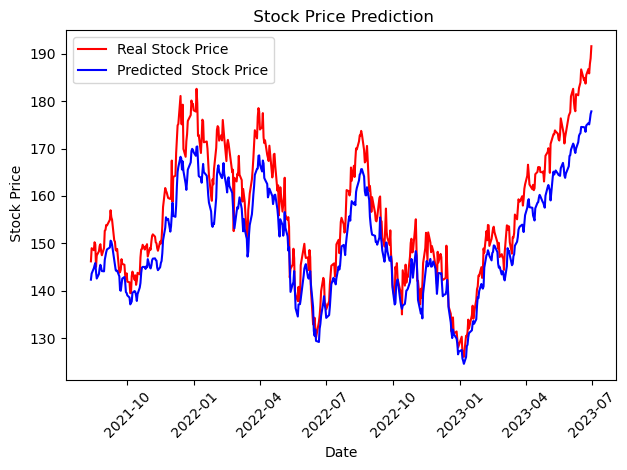

In [42]:
plt.plot(df_dates, original, color = 'red', label = 'Real Stock Price')
plt.plot(df_dates, pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel(' Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
df_30_days_past=df.iloc[-30:,:]

In [49]:
df_30_days_past

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-08-18,101.080002,103.470001,100.760002,101.410004,101.242561
2021-08-19,100.000000,100.820000,98.599998,99.419998,99.255844
2021-08-20,99.589996,100.669998,99.099998,100.050003,99.884804
2021-08-23,100.599998,101.480003,100.269997,100.970001,100.803284
2021-08-24,101.290001,103.510002,101.059998,103.269997,103.099487
2021-08-25,103.360001,105.129997,102.550003,104.699997,104.527122
2021-08-26,104.459999,104.620003,102.839996,103.379997,103.209305
2021-08-27,103.900002,106.150002,103.900002,106.089996,105.914825
2021-08-30,106.330002,106.459999,104.800003,105.190002,105.016312


In [50]:
df_30_days_future=pd.read_csv("test.csv",parse_dates=["Date"],index_col=[0])
df_30_days_future.shape

(30, 4)

In [51]:
df_30_days_future

,High,Low,Close,Adj Close
Date,,,,
2021-09-30,107.089996,102.949997,103.029999,102.939865
2021-10-01,106.389999,103.669998,105.820000,105.727425
2021-10-04,107.080002,104.599998,104.900002,104.808235
2021-10-05,106.000000,103.750000,104.900002,104.808235
2021-10-06,104.419998,102.059998,104.330002,104.238731
2021-10-07,106.529999,104.330002,105.510002,105.417702
2021-10-08,106.220001,104.660004,104.720001,104.628387
2021-10-11,105.760002,103.970001,104.080002,103.988953
2021-10-12,104.040001,101.559998,102.720001,102.630142


In [52]:
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
old_scaled_df=pd.DataFrame(old_scaled_array)
new_scaled_df=pd.DataFrame(new_scaled_array)

new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([old_scaled_df,new_scaled_df]).reset_index().drop(["index"],axis=1)

In [53]:
full_df.shape

(60, 5)

In [54]:
full_df.tail()

,0,1,2,3,4
55,NaN,0.143640,0.164162,0.150135,0.349458
56,NaN,0.152749,0.171268,0.159953,0.367565
57,NaN,0.154599,0.175349,0.159063,0.365924
58,NaN,0.171024,0.181345,0.167045,0.380645
59,NaN,0.161242,0.174766,0.160565,0.368694


In [55]:
full_df.shape

(60, 5)

In [56]:
full_df_scaled_array=full_df.values

In [57]:
full_df_scaled_array.shape

(60, 5)

In [58]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 17ms/step


In [86]:
all_data

[array([[0.1482769]], dtype=float32),
 array([[0.15000442]], dtype=float32),
 array([[0.1514765]], dtype=float32),
 array([[0.1526272]], dtype=float32),
 array([[0.15333982]], dtype=float32),
 array([[0.15340161]], dtype=float32),
 array([[0.15370393]], dtype=float32),
 array([[0.15395224]], dtype=float32),
 array([[0.15393883]], dtype=float32),
 array([[0.15323266]], dtype=float32),
 array([[0.1521465]], dtype=float32),
 array([[0.15122248]], dtype=float32),
 array([[0.1509795]], dtype=float32),
 array([[0.15092765]], dtype=float32),
 array([[0.15114477]], dtype=float32),
 array([[0.15176119]], dtype=float32),
 array([[0.15193477]], dtype=float32),
 array([[0.15188926]], dtype=float32),
 array([[0.15212983]], dtype=float32),
 array([[0.15332372]], dtype=float32),
 array([[0.15389305]], dtype=float32),
 array([[0.15412788]], dtype=float32),
 array([[0.15420789]], dtype=float32),
 array([[0.15464287]], dtype=float32),
 array([[0.15528473]], dtype=float32),
 array([[0.15572071]], dtype=f

In [92]:
new_array=np.array(all_data)
#new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array, 5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]

In [94]:
y_pred_future_30_days

array([104.84653 , 105.46312 , 105.98854 , 106.39925 , 106.653595,
       106.67565 , 106.783554, 106.872185, 106.8674  , 106.61535 ,
       106.22767 , 105.897865, 105.81114 , 105.79263 , 105.87013 ,
       106.09014 , 106.15211 , 106.135864, 106.221725, 106.64785 ,
       106.85106 , 106.93487 , 106.96343 , 107.11868 , 107.347786,
       107.503395, 107.54152 , 107.89776 , 108.40207 , 109.29391 ],
      dtype=float32)

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [74]:
my_model.save('Model_future_value.h5')
print('Model Saved!')

Model Saved!


In [75]:
scaler

MinMaxScaler()

In [76]:
import pickle
scalerfile = 'scaler_model_future_value.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))

# END!!!!